# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>AEC Enrolment data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally" data-toc-modified-id="First-preference-votes-nationally-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>First preference votes nationally</a></span></li><li><span><a href="#First-preferences-by-Division" data-toc-modified-id="First-preferences-by-Division-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>First preferences by Division</a></span></li><li><span><a href="#First-preference-by-state" data-toc-modified-id="First-preference-by-state-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>First preference by state</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li><li><span><a href="#Two-Party-Preferred-by-Division" data-toc-modified-id="Two-Party-Preferred-by-Division-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Two Party Preferred by Division</a></span></li><li><span><a href="#Two-candidate-preferred-by-Division" data-toc-modified-id="Two-candidate-preferred-by-Division-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Two candidate preferred by Division</a></span></li></ul></li></ul></li><li><span><a href="#Data-consistency-checks" data-toc-modified-id="Data-consistency-checks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data consistency checks</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#State-2pp-swings" data-toc-modified-id="State-2pp-swings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>State 2pp swings</a></span></li><li><span><a href="#State-primary-first-preference-swings" data-toc-modified-id="State-primary-first-preference-swings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>State primary first preference swings</a></span></li><li><span><a href="#Divisional-2pp-swings" data-toc-modified-id="Divisional-2pp-swings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Divisional 2pp swings</a></span></li><li><span><a href="#Green-TCP-swings" data-toc-modified-id="Green-TCP-swings-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Green TCP swings</a></span></li><li><span><a href="#Traditional-TCP-swings" data-toc-modified-id="Traditional-TCP-swings-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Traditional TCP swings</a></span></li></ul></li><li><span><a href="#Seat-allocations" data-toc-modified-id="Seat-allocations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Seat allocations</a></span><ul class="toc-item"><li><span><a href="#Tally-Class" data-toc-modified-id="Tally-Class-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tally Class</a></span></li><li><span><a href="#Thresholds-for-counting-purposes" data-toc-modified-id="Thresholds-for-counting-purposes-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Thresholds for counting purposes</a></span></li><li><span><a href="#Initialise-tally---apply-any-manual-blocks" data-toc-modified-id="Initialise-tally---apply-any-manual-blocks-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Initialise tally - apply any manual blocks</a></span></li><li><span><a href="#First-Preferences" data-toc-modified-id="First-Preferences-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>First Preferences</a></span></li><li><span><a href="#TCP-counts" data-toc-modified-id="TCP-counts-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>TCP counts</a></span></li><li><span><a href="#State-of-play" data-toc-modified-id="State-of-play-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>State of play</a></span></li><li><span><a href="#State-of-the-House" data-toc-modified-id="State-of-the-House-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>State of the House</a></span></li><li><span><a href="#House-outcome-and-closer-seats" data-toc-modified-id="House-outcome-and-closer-seats-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>House outcome and closer seats</a></span></li><li><span><a href="#Allocate-remainders-by-hand" data-toc-modified-id="Allocate-remainders-by-hand-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>Allocate remainders by hand</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# system imports
from pathlib import Path
import itertools
import numbers
import math
from datetime import datetime
from typing import Any, Union, Iterable, Optional, List, Dict

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat May 28 2022 14:31:24

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

pandas    : 1.4.2
matplotlib: 3.5.2
numpy     : 1.22.4

Watermark: 2.3.1



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = f'Election data from AEC {datetime.now().now().strftime("%d/%m/%Y %H:%M")}. '
LFOOTER

'Election data from AEC 28/05/2022 14:31. '

## Get data

### AEC Enrolment data

In [5]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preference votes nationally

In [6]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [7]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [8]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [9]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     36.182728
Labor         32.757968
Green         11.738443
One Nation     4.855287
UAP            4.074619
Other         10.390955
dtype: float64

#### First preferences by Division

In [10]:
houseFirstPrefsByCandidate = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
print(houseFirstPrefsByCandidate.TotalVotes.sum())
print(houseFirstPrefsByCandidate.columns)
fp_by_div = pd.pivot_table(houseFirstPrefsByCandidate, index='DivisionNm', 
                           columns='PartyAb', 
                           values='TotalVotes', aggfunc=pd.Series.sum)
fp_by_div.shape

13470961
Index(['StateAb', 'DivisionID', 'DivisionNm', 'CandidateID', 'Surname',
       'GivenNm', 'BallotPosition', 'Elected', 'HistoricElected', 'PartyAb',
       'PartyNm', 'OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
       'PrePollVotes', 'PostalVotes', 'TotalVotes', 'Swing'],
      dtype='object')


(151, 36)

In [11]:
assert not fp_by_div.columns.has_duplicates

In [12]:
fp_by_div.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,38302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,718.0,NaN,NaN,NaN,18670.0,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,27912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9938.0,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,37173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,571.0,NaN,NaN,NaN,11590.0,NaN,NaN,NaN,1632.0,NaN,NaN
Banks,NaN,28979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6864.0,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,19776.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.0,NaN,NaN,NaN,6756.0,NaN,NaN,NaN,4544.0,NaN,NaN
Barton,NaN,39954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9329.0,NaN,NaN,NaN,NaN,NaN,NaN
Bass,819.0,16825.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6260.0,NaN,NaN,NaN,2901.0,3868.0,NaN
Bean,NaN,38771.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13364.0,NaN,NaN,NaN,7571.0,NaN,NaN
Bendigo,NaN,39676.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12307.0,NaN,NaN,NaN,3871.0,NaN,NaN


In [13]:
# the least counted
fp_count_pct = fp_by_div.sum(axis=1) / enrolment_div * 100
fp_count_pct.sort_values().head()

DivisionNm
Lingiari     58.185010
Durack       59.063918
Melbourne    61.348048
McMahon      64.382362
Sydney       64.795369
dtype: float64

In [14]:
# the most counted
fp_count_pct.sort_values().tail()

DivisionNm
Clark       82.812145
Deakin      82.991234
Franklin    83.306569
Calare      83.419433
Bean        83.986418
dtype: float64

In [15]:
fp_vote_pct = (fp_by_div.div(fp_by_div.sum(axis=1), axis=0) * 100).round(2)
fp_vote_pct.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,40.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76,NaN,NaN,NaN,19.70,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,32.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.65,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,45.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.70,NaN,NaN,NaN,14.13,NaN,NaN,NaN,1.99,NaN,NaN
Banks,NaN,35.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.35,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,20.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN,7.15,NaN,NaN,NaN,4.81,NaN,NaN
Barton,NaN,51.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.92,NaN,NaN,NaN,NaN,NaN,NaN
Bass,1.41,28.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.76,NaN,NaN,NaN,4.98,6.65,NaN
Bean,NaN,42.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.52,NaN,NaN,NaN,8.23,NaN,NaN
Bendigo,NaN,43.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,NaN,NaN,NaN,4.24,NaN,NaN


#### First preference by state 

In [16]:
houseFirstPrefsByStateByParty2022 = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByStateByPartyDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2022 = houseFirstPrefsByStateByParty2022.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2019 = (
    pd.read_csv('https://results.aec.gov.au/24310/Website/'
                'Downloads/HouseFirstPrefsByStateByPartyDownload-24310.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2019 = houseFirstPrefsByStateByParty2019.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2022

,StateAb,PartyNm,OrderOfAppearance,Contested,Nominations,Elected,OrdinaryVotes,OrdinaryPercentage,AbsentVotes,AbsentPercentage,ProvisionalVotes,ProvisionalPercentage,DeclarationPrePollVotes,DeclarationPrePollPercentage,PostalVotes,PostalPercentage,TotalVotes,TotalPercentage,TotalSwing
PartyAb,,,,,,,,,,,,,,,,,,,
LP,NSW,Liberal,1,38,38,0,1061780,27.80,526,24.00,0,0.0,0,0.0,109681,36.06,1171987,28.41,-4.38
NP,NSW,The Nationals,2,9,9,0,335255,8.78,0,0.00,0,0.0,0,0.0,20420,6.71,355675,8.62,-1.14
ALP,NSW,Australian Labor Party,3,47,47,0,1278193,33.47,802,36.59,0,0.0,0,0.0,98290,32.32,1377285,33.38,-1.18
UAPP,NSW,United Australia Party,4,47,47,0,152409,3.99,94,4.29,0,0.0,0,0.0,7580,2.49,160083,3.88,0.50
IND,NSW,Independent,5,27,37,0,296771,7.77,23,1.05,0,0.0,0,0.0,20602,6.77,317396,7.69,3.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDP,NT,Liberal Democratic Party,4,2,2,0,6408,7.32,169,9.66,0,0.0,0,0.0,360,8.49,6937,7.42,7.42
ON,NT,Pauline Hanson's One Nation,5,2,2,0,4504,5.15,118,6.74,0,0.0,0,0.0,267,6.30,4889,5.23,5.23
UAPP,NT,United Australia Party,6,2,2,0,3889,4.44,115,6.57,0,0.0,0,0.0,113,2.67,4117,4.40,1.55


#### Two party preferred votes by state

In [17]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1595516,48.73,1678867,51.27,3274383,-3.05,5472469,59.833742
VIC,VIC,Victoria,1165197,45.35,1404204,54.65,2569401,-1.51,4344208,59.145441
QLD,QLD,Queensland,1215134,54.90,998197,45.10,2213331,-3.54,3503609,63.172888
WA,WA,Western Australia,507729,44.42,635411,55.58,1143140,-11.13,1773969,64.439683
SA,SA,South Australia,372953,45.70,443187,54.30,816140,-3.59,1272047,64.159579
TAS,TAS,Tasmania,127579,48.92,133202,51.08,260781,4.88,402331,64.817526
ACT,ACT,Australian Capital Territory,62484,35.47,113676,64.53,176160,-2.92,314329,56.043190
NT,NT,Northern Territory,41281,44.14,52233,55.86,93514,-1.66,145938,64.077896


In [18]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

51.75931202207295

#### Two Party Preferred by Division

In [19]:
houseTppByDivision = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTppByDivisionDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTppByDivision.index = houseTppByDivision['DivisionNm']
houseTppByDivision['Enrolment'] = enrolment_div
houseTppByDivision['Counted%'] =  houseTppByDivision['TotalVotes'] / houseTppByDivision['Enrolment']* 100.0

# IMPORTANT -- How many electorates are missing TPP vote data
houseTppByDivision[(houseTppByDivision['Counted%'] == 0.0)]

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
DivisionNm,,,,,,,,,,,,
Bradfield,Bradfield,108,NSW,NaN,0,0.0,0,0.0,0,-66.56,108573,0.0
Calare,Calare,109,NSW,NaN,0,0.0,0,0.0,0,-63.29,121564,0.0
Canberra,Canberra,101,ACT,NaN,0,0.0,0,0.0,0,-32.92,102196,0.0
Clark,Clark,319,TAS,NaN,0,0.0,0,0.0,0,-33.83,74797,0.0
Cooper,Cooper,320,VIC,NaN,0,0.0,0,0.0,0,-23.79,108730,0.0
Cowper,Cowper,113,NSW,NaN,0,0.0,0,0.0,0,-61.88,129887,0.0
Curtin,Curtin,238,WA,NaN,0,0.0,0,0.0,0,-63.95,119397,0.0
Fowler,Fowler,119,NSW,NaN,0,0.0,0,0.0,0,-36.01,108517,0.0
Goldstein,Goldstein,214,VIC,NaN,0,0.0,0,0.0,0,-57.79,109773,0.0


In [20]:
# make a more useful index
houseTppByDivision.index = (
    houseTppByDivision['DivisionNm'] + ' (' + 
    houseTppByDivision['StateAb'] + ')'
)
houseTppByDivision.head()

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,36176,38.18,58577,61.82,94753,-3.64,130151,72.802360
Aston (VIC),Aston,197,VIC,NaN,44883,53.18,39523,46.82,84406,-6.95,109826,76.854297
Ballarat (VIC),Ballarat,198,VIC,NaN,30173,36.79,51831,63.21,82004,-2.98,110704,74.075011
Banks (NSW),Banks,103,NSW,NaN,44144,53.68,38095,46.32,82239,-2.58,107786,76.298406
Barker (SA),Barker,180,SA,NaN,63068,66.72,31462,33.28,94530,-2.22,123518,76.531356


#### Two candidate preferred by Division

In [21]:
houseTcp = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTcpByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTcp.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,N,Y,ALP,Australian Labor Party,53455,0,0,0,4763,58218,5.75
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,30778,0,0,0,3020,33798,-5.75
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,28500,0,0,0,2526,31026,37.52
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,N,Y,ALP,Australian Labor Party,46887,0,0,0,4782,51669,62.48
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,N,Y,ALP,Australian Labor Party,50943,0,0,0,4515,55458,5.35


In [22]:
COALITION = ['LNP', 'LP', 'NP', 'CLP']
tcp_swings = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='Swing', columns='PartyAb')

# check we do not have any Coalition v Coalition contests
assert (tcp_swings[COALITION].notna().sum(axis=1) <= 1).any()

In [23]:
tcp_swings['Coalition'] = (
    tcp_swings[COALITION].sum(axis=1)
    .where(tcp_swings[COALITION].notna().any(axis=1), other=np.nan)
)
tcp_swings = tcp_swings.drop(columns=COALITION)
tcp_swings.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,3.64,NaN,NaN,NaN,NaN,-3.64
Aston,6.95,NaN,NaN,NaN,NaN,-6.95
Ballarat,2.98,NaN,NaN,NaN,NaN,-2.98
Banks,2.58,NaN,NaN,NaN,NaN,-2.58
Barker,2.22,NaN,NaN,NaN,NaN,-2.22


In [24]:
raw_tcp_votes = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='TotalVotes', columns='PartyAb')

# Check for Coalition v Coalition contests
assert (raw_tcp_votes[COALITION].notna().sum(axis=1) <= 1).any()

cooked_tcp_votes = raw_tcp_votes.copy()
cooked_tcp_votes['Coalition'] = (
    cooked_tcp_votes[COALITION].sum(axis=1)
    .where(cooked_tcp_votes[COALITION].notna().any(axis=1), other=np.nan)
)
cooked_tcp_votes = cooked_tcp_votes.drop(columns=COALITION)
cooked_tcp_counted = cooked_tcp_votes.sum(axis=1) / enrolment_div * 100 

In [25]:
# convert to per cents
raw_pct_tcp_votes = raw_tcp_votes.div(raw_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes = cooked_tcp_votes.div(cooked_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,61.820734,NaN,NaN,NaN,NaN,38.179266
Aston,46.824870,NaN,NaN,NaN,NaN,53.175130
Ballarat,63.205453,NaN,NaN,NaN,NaN,36.794547
Banks,46.322305,NaN,NaN,NaN,NaN,53.677695
Barker,33.282556,NaN,NaN,NaN,NaN,66.717444


## Data consistency checks

In [26]:
# All first preferences
assert houseFirstPrefsByParty.TotalVotes.sum() == fp_by_div.sum().sum()
houseFirstPrefsByParty.TotalVotes.sum()

12784166

In [27]:
# TPP
assert houseTppByState.TotalVotes.sum() == houseTppByDivision.TotalVotes.sum()
houseTppByDivision.TotalVotes.sum()

10546850

## Plots

### State 2pp swings

In [29]:
def set_up_swing_chart(data:pd.Series):
    
    assert isinstance(data, pd.Series)
    fig, ax = common.initiate_plot()
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)

    rightax = ax.twinx()
    ax.get_shared_y_axes().join(ax, rightax)
    rightax.grid(False)
    
    sorted_data = data.sort_values()
    labels = sorted_data.index
    sorted_data = sorted_data.reset_index(drop=True)
    
    ylims = sorted_data.index.min() - 0.5, sorted_data.index.max() + 0.5
    ax.set_ylim(ylims)
    rightax.set_ylim(ylims)
   
    return ax, rightax, sorted_data, labels


def finalise_swing_chart(ax, rightax, data, labels):

    ax.yaxis.set_ticks_position('left')
    rightax.yaxis.set_ticks_position('right')
    ax.spines['left'].set_position(('data',0),)
    ax.spines['left'].set_color('#999999')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    rightax.spines['right'].set_position(('data',0))

    ax.set_yticks(data.index)
    rightax.set_yticks(data.index)

    ax.set_yticklabels(labels.where(data >= 0, other=''))
    rightax.set_yticklabels(labels.where(data < 0, other=''))


In [30]:
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1595516,48.73,1678867,51.27,3274383,-3.05,5472469,59.833742
VIC,VIC,Victoria,1165197,45.35,1404204,54.65,2569401,-1.51,4344208,59.145441
QLD,QLD,Queensland,1215134,54.90,998197,45.10,2213331,-3.54,3503609,63.172888
WA,WA,Western Australia,507729,44.42,635411,55.58,1143140,-11.13,1773969,64.439683
SA,SA,South Australia,372953,45.70,443187,54.30,816140,-3.59,1272047,64.159579
TAS,TAS,Tasmania,127579,48.92,133202,51.08,260781,4.88,402331,64.817526
ACT,ACT,Australian Capital Territory,62484,35.47,113676,64.53,176160,-2.92,314329,56.043190
NT,NT,Northern Territory,41281,44.14,52233,55.86,93514,-1.66,145938,64.077896


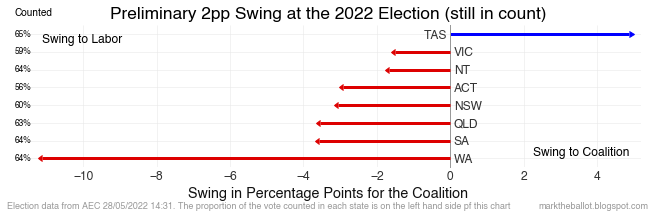

In [31]:
# marshall our data
data = houseTppByState['Swing']

# plot our data
ax, rightax, data, labels = set_up_swing_chart(houseTppByState['Swing'])
ax.figure.set_size_inches(9, 3)
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each state
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByState.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

# annotate axes
ax.text(data.min(), data.index.max(), 'Swing to Labor',
        ha='left', va='top', fontsize='large')
ax.text(data.max(), data.index.min(), 'Swing to Coalition',
        ha='right', va='bottom', fontsize='large')

common.plot_finalise(
    ax, 
    title='Preliminary 2pp Swing at the 2022 Election (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points for the Coalition', 
    lfooter=LFOOTER +
            'The proportion of the vote counted in each state is on the left hand side pf this chart', 
)

### State primary first preference swings

In [32]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}

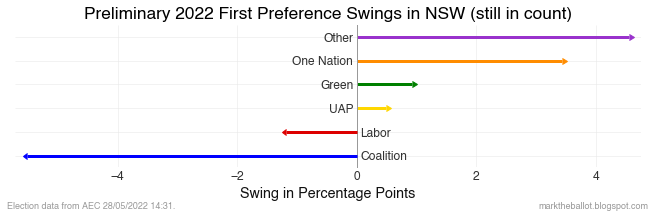

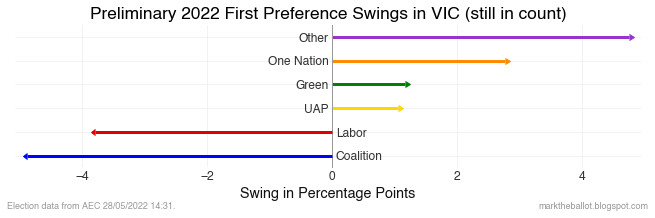

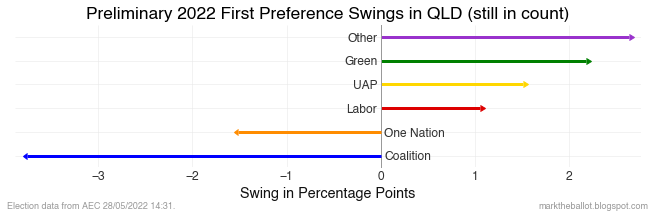

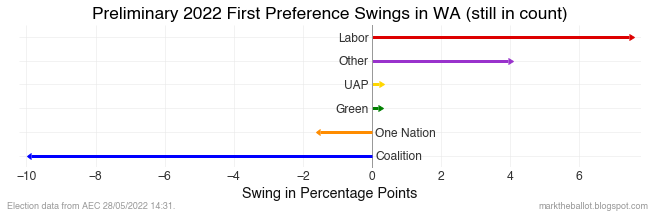

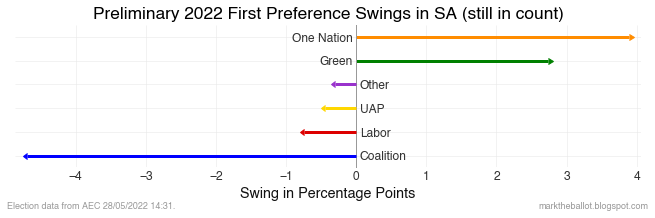

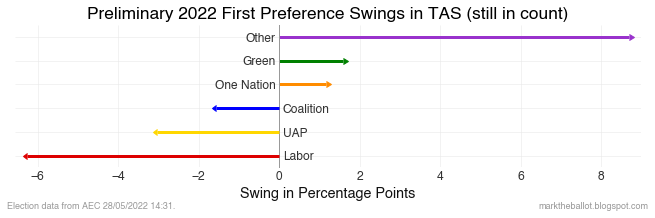

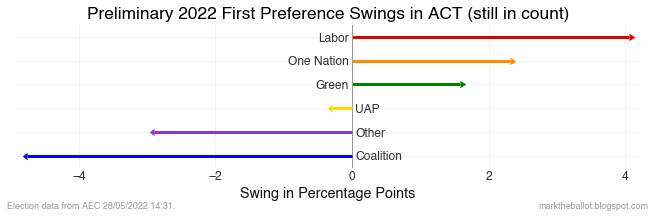

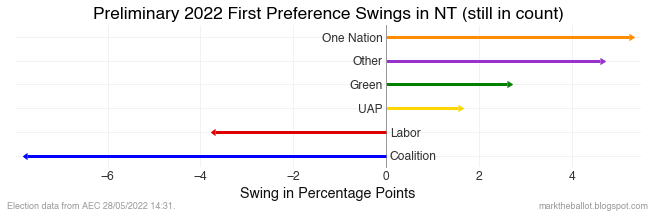

In [33]:
d22 = houseFirstPrefsByStateByParty2022
d19 = houseFirstPrefsByStateByParty2019

combined = {}
for state in d22['StateAb'].unique():

    # data marshalling 
    state2022 = d22[d22['StateAb'] == state].copy()
    state2019 = d19[d19['StateAb'] == state].copy()
    grouped2022 = get_group_totals(state2022)
    grouped2019 = get_group_totals(state2019)
    swings2022 = (grouped2022 - grouped2019).sort_values()
    for group, value in swings2022.iteritems():
        if group in combined:
            combined[group] = combined[group] | {state: value} # Python 3.10 feature
        else:
            combined[group] = {state: value}
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(swings2022)
    ax.figure.set_size_inches(9, 3)


    for x, y, l in zip(data, data.index, labels):
        ecolor = colours[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)

    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings in {state} (still in count)',
        ylabel=None,
        xlabel='Swing in Percentage Points', 
        lfooter=LFOOTER, 
    )    

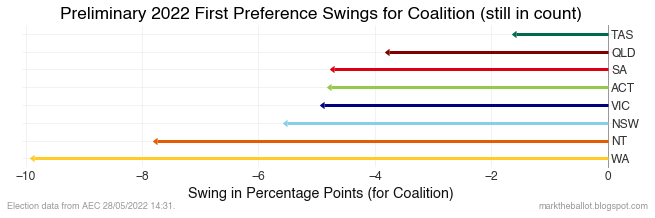

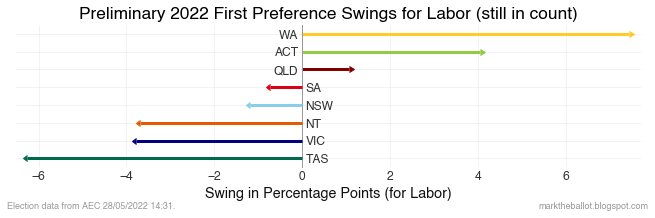

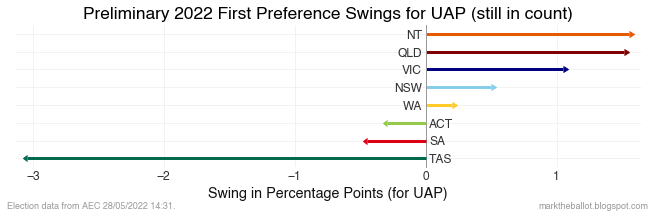

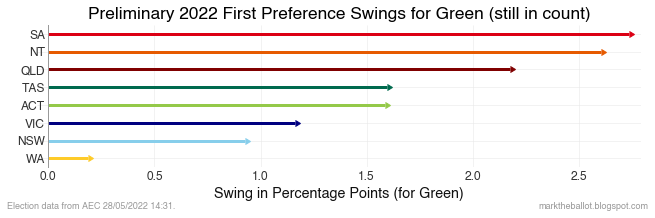

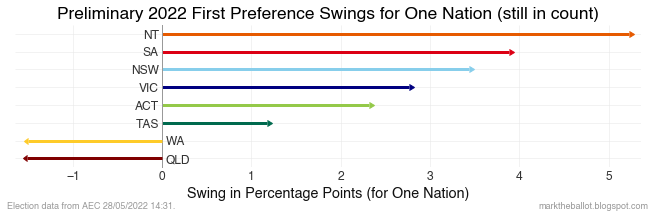

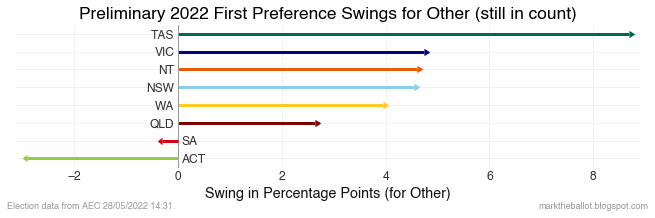

In [34]:
state_palette = {
    # colours from the R strayr package
    "NSW": '#87ceeb',
    "VIC": '#000080', 
    "QLD": '#800000', 
    "WA": '#fecb29', 
    "SA": '#dc0014', 
    "TAS": '#006a4e', 
    "ACT": '#94c949', 
    "NT": '#e65a00',
}

for group, dict_ in combined.items():
    
    # data
    series = pd.Series(dict_)
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(series)
    ax.figure.set_size_inches(9, 3)
    
    for x, y, l in zip(data, data.index, labels):
        ecolor = state_palette[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)
    
    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings for {group} (still in count)',
        ylabel=None,
        xlabel=f'Swing in Percentage Points (for {group})', 
        lfooter=LFOOTER, 
    )        


### Divisional 2pp swings

In [35]:
houseTppByDivision

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,36176,38.18,58577,61.82,94753,-3.64,130151,72.802360
Aston (VIC),Aston,197,VIC,NaN,44883,53.18,39523,46.82,84406,-6.95,109826,76.854297
Ballarat (VIC),Ballarat,198,VIC,NaN,30173,36.79,51831,63.21,82004,-2.98,110704,74.075011
Banks (NSW),Banks,103,NSW,NaN,44144,53.68,38095,46.32,82239,-2.58,107786,76.298406
Barker (SA),Barker,180,SA,NaN,63068,66.72,31462,33.28,94530,-2.22,123518,76.531356
...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa (NSW),Werriwa,153,NSW,NaN,37448,44.84,46060,55.16,83508,0.31,126141,66.202107
Whitlam (NSW),Whitlam,150,NSW,NaN,40239,40.00,60350,60.00,100589,0.91,125535,80.128251
Wide Bay (QLD),Wide Bay,178,QLD,NaN,50870,61.59,31722,38.41,82592,-1.56,115420,71.557789
Wills (VIC),Wills,234,VIC,NaN,0,0.00,0,0.00,0,-24.29,108500,0.000000


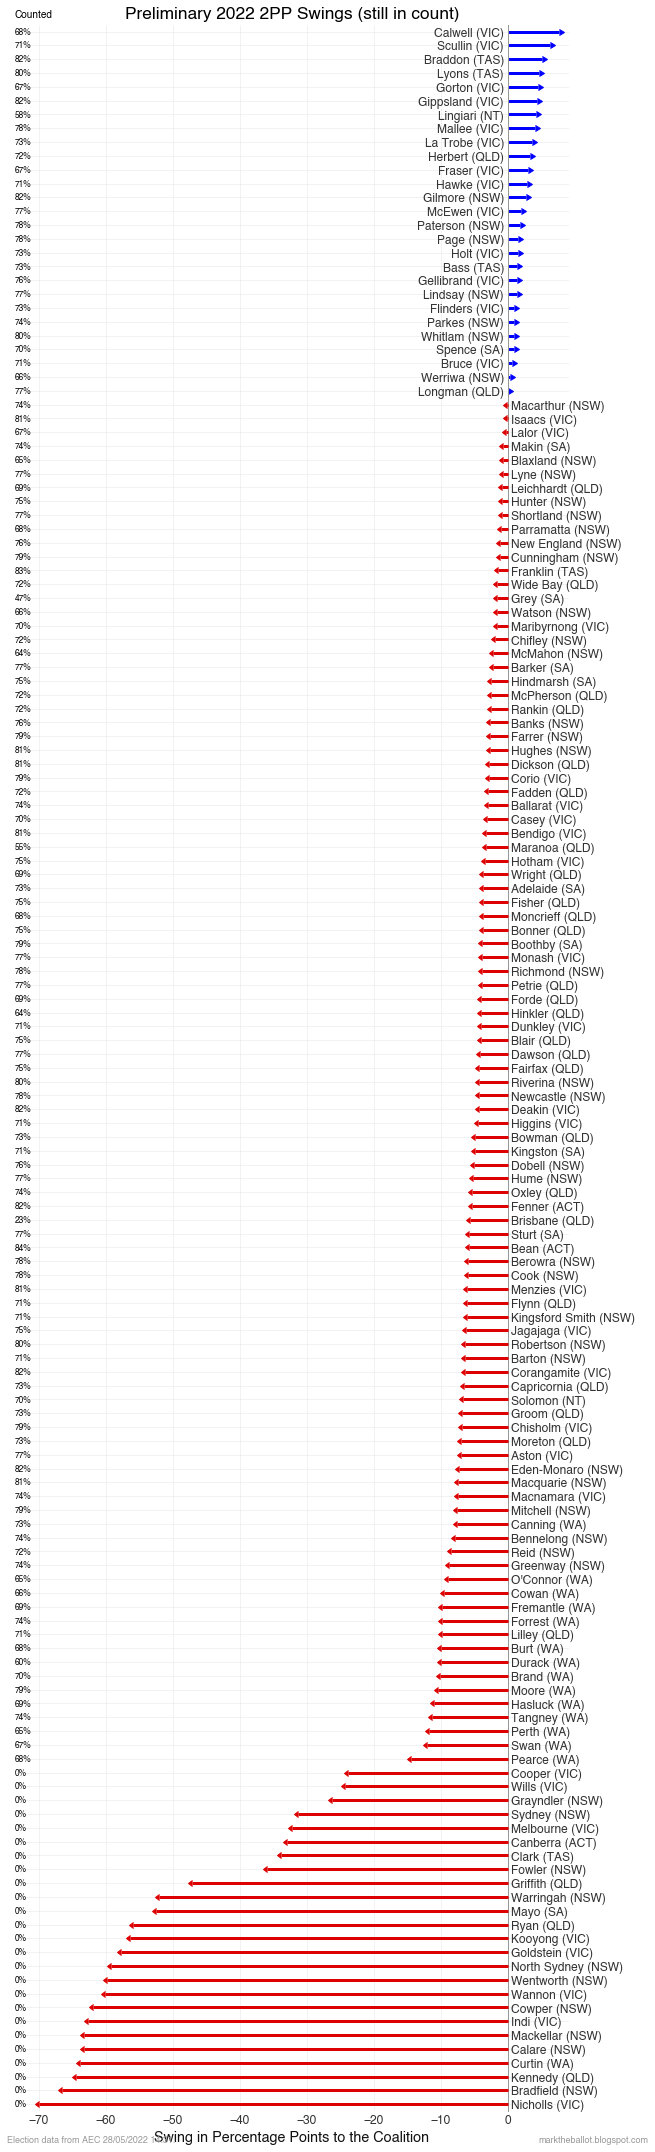

In [36]:
data = houseTppByDivision['Swing'].copy()
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9, 30)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')

finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByDivision.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Preliminary 2022 2PP Swings (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=LFOOTER, 
)    

### Green TCP swings

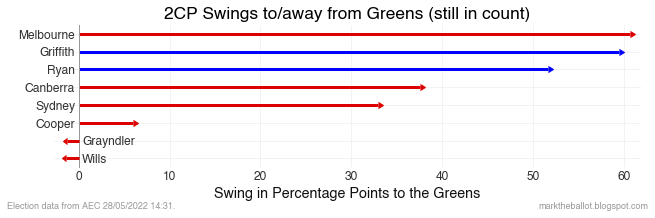

In [37]:
x_colors = {
    'ALP': '#dd0000',
    'Coalition': 'blue',
    'GRN': 'limegreen',
    'IND': 'darkorange'
}

GREEN = 'GRN'
orig_ = tcp_swings[tcp_swings[GREEN].notna()]
greens = orig_[GREEN]

ax, rightax, series, labels = set_up_swing_chart(greens)
ax.figure.set_size_inches(9, 3)

# plot our data
for x, y, label in zip(series, series.index, labels):
    kommen = orig_.drop(GREEN, axis=1).loc[label].idxmax()
    c = x_colors[kommen]
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=c)
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=c)
        
finalise_swing_chart(ax, rightax, series, labels)

common.plot_finalise(
    ax, 
    title=f'2CP Swings to/away from Greens (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Greens', 
    lfooter=LFOOTER, 
) 

### Traditional TCP swings

In [38]:
missing = tcp_swings.isna().all(axis=1)
missing_text = f'Missing from AEC feed: {(", ").join(missing[missing].index)}.' if missing.any() else ''
missing_text

''

In [39]:
TRADITIONAL = ['ALP', 'Coalition']
data = tcp_swings[tcp_swings[TRADITIONAL].notna().all(axis=1)]
data = data['Coalition']
data

DivisionNm
Adelaide   -3.64
Aston      -6.95
Ballarat   -2.98
Banks      -2.58
Barker     -2.22
            ... 
Watson     -1.60
Werriwa     0.31
Whitlam     0.91
Wide Bay   -1.56
Wright     -3.64
Name: Coalition, Length: 126, dtype: float64

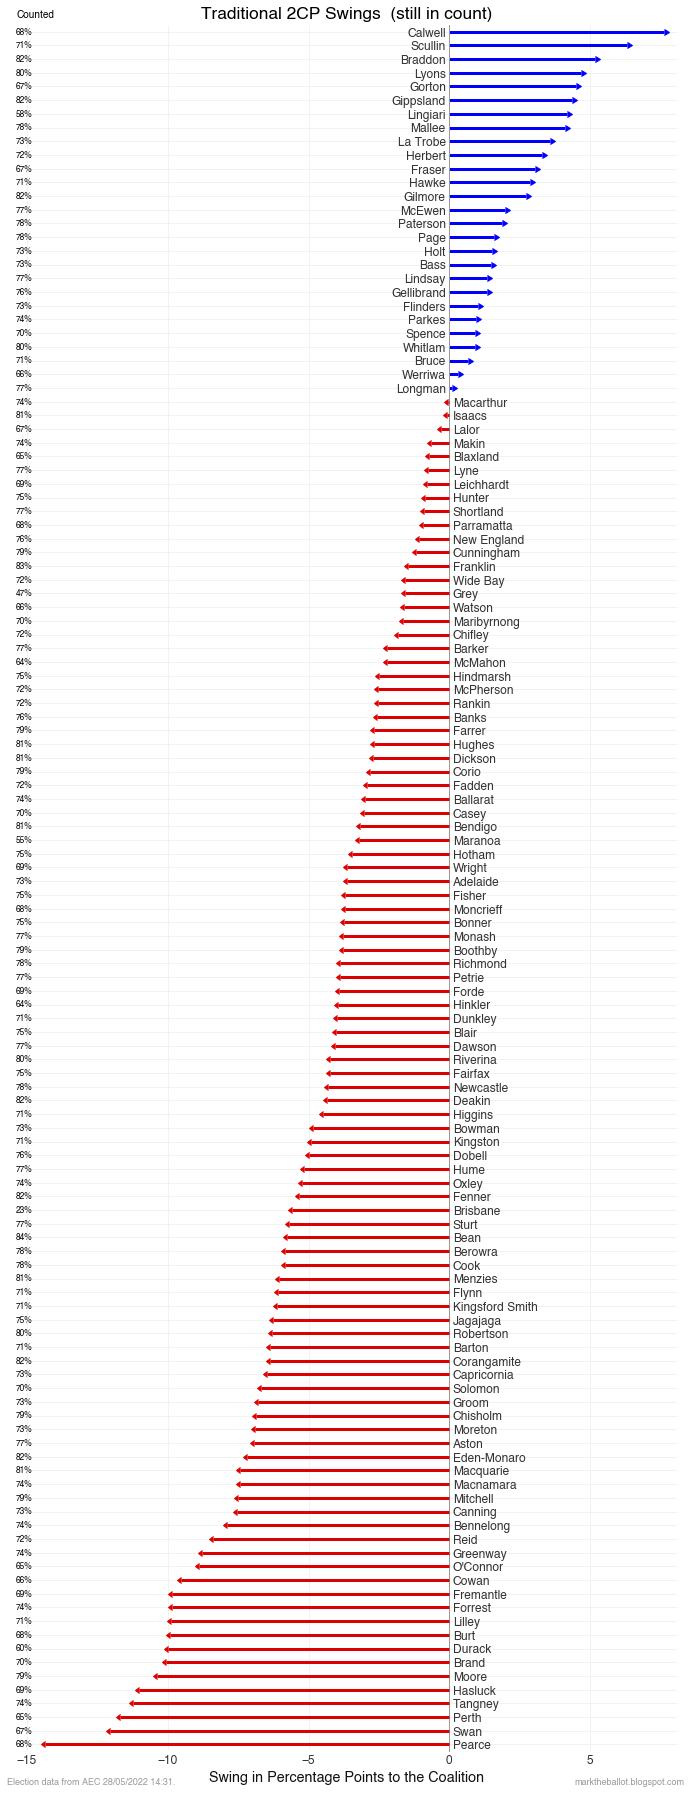

In [40]:
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9.5, 25)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{cooked_tcp_counted[label]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Traditional 2CP Swings  (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=f'{LFOOTER}{missing_text}', 
)    

In [41]:
tcp_swings.loc['Brisbane']

PartyAb
ALP          5.58
GRN           NaN
IND           NaN
KAP           NaN
XEN           NaN
Coalition   -5.58
Name: Brisbane, dtype: float64

## Seat allocations

### Tally Class

In [42]:
class Tally:
    
    UNALLOCATED = 'Unallocated'
    STAR = '*'
    
    def __init__(self, seat_list: List[str]):
        """Create a Tally with seats from seat_list and ouctome
           categories from the outcome_list. Initialise with all
           seats in the 'Unallocated' category."""
        self.tally = {}
        self.tally[self.UNALLOCATED] = set(seat_list)
        self.block_list = []

        
    def set_manual_block(self, block_list: List[str]) -> None:
        """Provide a list of seats that cannot be moved."""
        self.block_list = block_list

        
    def move(self, bundle: List[str], source:str, dest:str) -> None:
        """Move seats in bundle list from the source outcome category 
           to the destination outcome category"""
        if dest not in self.tally.keys():
            self.tally[dest] = set()
        moving = set(bundle).intersection(self.tally[source])
        moving.difference_update(self.block_list)
        self.tally[source].difference_update(moving)
        self.tally[dest].update(moving)

        
    def get_seat_stringlist(self, outcome_cat: str)-> str:
        """Return a comma separated list of seats in the 
           desired outcome strategy"""
        return ', '.join(sorted(self.tally[outcome_cat]))
    
    def get_seat_list(self, outcome_cat: str)-> List[str]:
        return sorted(self.tally[outcome_cat])
    
    def get_seat_count(self, outcome_cat: str)-> str:
        """Return the seat coun for a specific outcome category"""
        return len(self.tally[outcome_cat])

    
    def get_seat_counts(self) -> pd.Series:
        s = {}
        for outcome, seats in self.tally.items():
            s[outcome] = len(seats)
        return pd.Series(s)

            
    def print_all_results(self) -> None:
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)} - '
                  f'({self.get_seat_stringlist(outcome)})')

            
    def print_all_counts(self) -> None:
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)}')


    def _update_assign_map(self, assignmap: Dict[str, str], df: pd.DataFrame):
        if self.STAR in assignmap.keys():
            assignmap = assignmap.copy()
            left_overs = set(df.columns)
            left_overs.difference_update(set(assignmap.keys()))
            for k in left_overs:
                assignmap[k] = assignmap[self.STAR]
        return assignmap

    
    def _make_assignment(self, df: pd.DataFrame, 
                         count_s: pd.Series,
                         assignmap: Dict[str, str], 
                         thresholds: Dict[float, float]):
        for vote_t, count_t in thresholds.items():
            frame = df.loc[
                (df.max(axis=1) > vote_t)
                & (count_s > count_t)
            ]
            if len(frame) == 0:
                contine
            movers = frame.idxmax(axis=1)
            for party in movers.unique():
                bundle = movers[movers == party].index.to_list()
                self.move(bundle, self.UNALLOCATED, assignmap[party])

                
    def assign(self, vote_df: pd.DataFrame, 
               count_s: pd.Series,
               assignmap: Dict[str, str], 
               thresholds: Dict[float, float]):
        assignmap = self._update_assign_map(assignmap, vote_df)
        self._make_assignment(vote_df, count_s, assignmap, thresholds)


### Thresholds for counting purposes

In [43]:
TCP_THRESH = {
    # Threshholds for moving a seat from unallocated ...
    # TCP_vote_threshold, TCP_count_threshold (%)
    50.25: 80.0,
    50.35: 75.0,
    50.5:  70.0,
    51.0:  60.0,
    51.5:  50.0,
    55.0:  40.0,
    60.0:  40.0,
}

FP_THRESH = {
    # Vote, Count
    50.0: 40,
    45.0: 70, #### Think about this assumption ...
}

seat_list = fp_by_div.index.to_list()

assign_map = {
    # Thresholds for assigning seat based on a column in 
    # a DataFrame (seats x party) and a set threshold
    
    # DataFrame Party, Outcome Category
    'Coalition': 'Coalition',
    'LP': 'Coalition',
    'LNP': 'Coalition',
    'CLP': 'Coalition',
    'NP': 'Coalition',
    'Labor': 'Labor',
    'ALP': 'Labor',
    'GRN': 'Green',
    'IND': 'Independent', 
    '*': 'Other',  # Use star for mopping up others ...
}

### Initialise tally - apply any manual blocks

In [44]:
MANUAL_BLOCK = set(['Brisbane', 'Macnamara'])

tally = Tally(seat_list)
tally.set_manual_block(MANUAL_BLOCK)

### First Preferences

In [45]:
tally.assign(fp_vote_pct, fp_count_pct, assign_map, FP_THRESH)
tally.get_seat_counts()

Unallocated    106
Coalition       23
Labor           19
Green            1
Independent      2
dtype: int64

### TCP counts

In [46]:
tally.assign(cooked_pct_tcp_votes, cooked_tcp_counted, assign_map, TCP_THRESH)
house = tally.get_seat_counts().sort_values()
house

Other           2
Green           3
Unallocated     4
Independent    10
Coalition      58
Labor          74
dtype: int64

### State of play

In [47]:
tally.print_all_results() 

Unallocated: 4 - (Brisbane, Gilmore, Lingiari, Macnamara)
Coalition: 58 - (Aston, Banks, Barker, Bass, Berowra, Bonner, Bowman, Braddon, Bradfield, Calare, Canning, Capricornia, Casey, Cook, Cowper, Dawson, Deakin, Dickson, Durack, Fadden, Fairfax, Farrer, Fisher, Flinders, Flynn, Forde, Forrest, Gippsland, Grey, Groom, Herbert, Hinkler, Hughes, Hume, La Trobe, Leichhardt, Lindsay, Longman, Lyne, Mallee, Maranoa, McPherson, Menzies, Mitchell, Monash, Moncrieff, Moore, New England, Nicholls, O'Connor, Page, Parkes, Petrie, Riverina, Sturt, Wannon, Wide Bay, Wright)
Labor: 74 - (Adelaide, Ballarat, Barton, Bean, Bendigo, Bennelong, Blair, Blaxland, Boothby, Brand, Bruce, Burt, Calwell, Canberra, Chifley, Chisholm, Cooper, Corangamite, Corio, Cowan, Cunningham, Dobell, Dunkley, Eden-Monaro, Fenner, Franklin, Fraser, Fremantle, Gellibrand, Gorton, Grayndler, Greenway, Hasluck, Hawke, Higgins, Hindmarsh, Holt, Hotham, Hunter, Isaacs, Jagajaga, Kingsford Smith, Kingston, Lalor, Lilley, Lyons

### State of the House

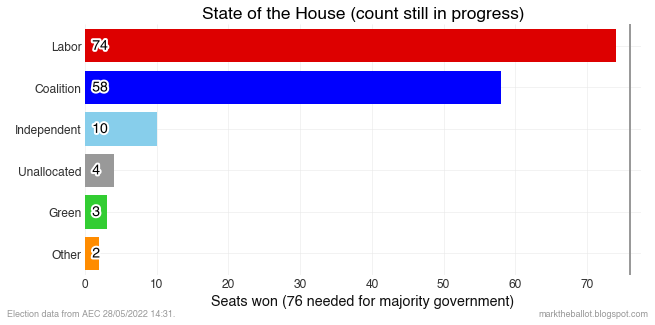

In [48]:
def plot_state_of_house(tally, title):
    
    cmap = {
        'Labor': '#dd0000',
        'Coalition': 'blue',
        'Independent': 'skyblue',
        'Unallocated': '#999999',
        'Green': 'limegreen',
        'Other': 'darkorange',
    }
    
    house = tally.get_seat_counts().sort_values()

    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    ax.axvline(76, c='#999999')
    for party, count in house.iteritems():
        if count <= 0:
            continue
        ax.barh(party, count, color=cmap[party])
        text = ax.text(1, party, f'{count}', ha='left', va='center', fontsize=14)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Seats won (76 needed for majority government)',
        lfooter=LFOOTER, 
    )
    
plot_state_of_house(tally, 'State of the House (count still in progress)')

### House outcome and closer seats

In [49]:
def get_close(close):
    close_tcp_votes = cooked_pct_tcp_votes.loc[close]
    max_value = close_tcp_votes.max(axis=1)
    max_label = close_tcp_votes.idxmax(axis=1)
    min_label = close_tcp_votes.idxmin(axis=1)
    return (
        pd.DataFrame({'Values': max_value.values, 
                      'Group': max_label.values, 
                      'Seat': close_tcp_votes.index },
                      index=[f'{seat} {a}-vs-{b}' 
                             for seat, a, b in zip(close_tcp_votes.index, max_label, min_label)],)
    ).sort_values('Values')


In [50]:
def plot_close(data:pd.DataFrame, title):
    
    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for x, y, c in zip(data['Values'], data.index, data['Group']):
        if math.isnan(x):
            x=50
        color = x_colors[c] if c in x_colors else 'white'
        ax.barh(y, x-50, left=50, color=color)

    # add in the count completion percentages for each division
    xlim_lo, xlim_high = ax.get_xlim()
    adj = (xlim_high - xlim_lo) * 0.025
    ax.set_xlim(xlim_lo, xlim_high+adj)
    for y, label in enumerate(data['Seat']):
        if math.isnan(x):
            continue
        text = f'{cooked_tcp_counted[label]:0.0f}%'
        ax.text(xlim_high+adj, y, text, ha='right', va='center', fontsize='small')
    ax.text(xlim_high+adj, y+0.8, 'Counted', ha='right', va='center', )

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Per cent two-candidate-preferred vote share', 
        lfooter=LFOOTER, 
    )

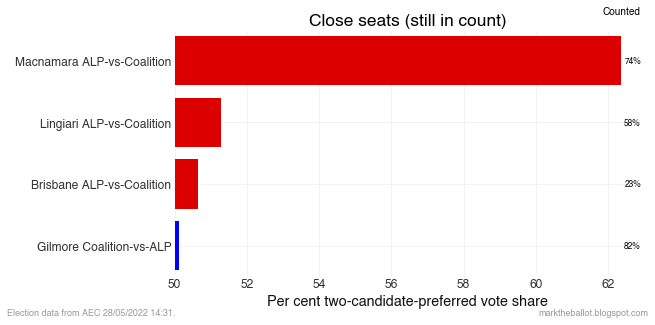

In [51]:
close = get_close(tally.get_seat_list(tally.UNALLOCATED))
plot_close(close, 'Close seats (still in count)')

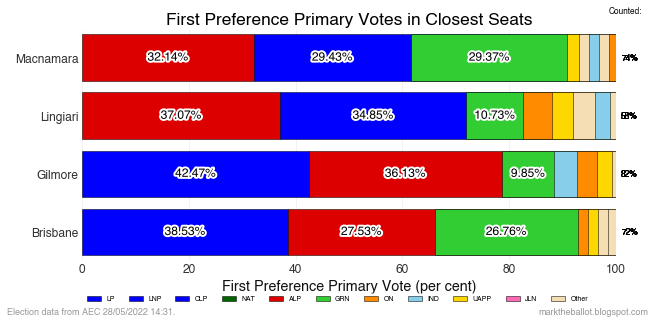

In [52]:
# Primaries for close counts
def plot_primaries(seats):
    seats = sorted(seats)
    
    colors = {
        'LP': 'blue',
        'LNP': 'blue',
        'CLP': 'blue',
        'NAT': 'darkgreen',
        'ALP': '#dd0000',
        'GRN': 'limegreen',
        'ON': 'darkorange',
        'IND': 'skyblue',
        'UAPP': 'gold',
        'JLN': 'hotpink',
        'Other': 'wheat',
    }
    fig, ax = fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for seat in seats:
        primary = fp_vote_pct.loc[seat].dropna().sort_values(ascending=False)
        tally = 0.0
        for party, vote in primary.iteritems():
            color = colors['Other'] if party not in colors else colors[party]
            if tally == 0.0:
                ax.barh(seat, vote, color=color, edgecolor='black', linewidth=0.5)
            else:
                ax.barh(seat, tally+vote, left=tally, color=color, edgecolor='black', linewidth=0.5)
            if vote > 8:
                text = ax.text(tally+(vote/2), seat, f'{vote:0.2f}%', ha='center', va='center',
                    fontsize=12)
                text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])
            tally += vote
            count = f'{fp_count_pct[seat]:0.0f}%'
            ax.text(101, seat, count, ha='left', va='center', fontsize='small', fontweight='normal')
    ax.set_xlim((0, 100))
    ax.text(105, len(seats)-0.2, 'Counted:', ha='right', va='center', fontsize='small', )

    elements = []
    for party, color in colors.items():
        elements.append(Patch(facecolor=color, edgecolor='black', linewidth=0.5, label=party))
    ax.legend(handles=elements, loc='best', ncol=len(elements),
              bbox_to_anchor=(0.96, -0.13), )
    
    common.plot_finalise(
        ax, 
        title='First Preference Primary Votes in Closest Seats',
        ylabel=None,
        xlabel='First Preference Primary Vote (per cent)', 
        lfooter=LFOOTER, 
    )
    
    
plot_primaries(tally.get_seat_list(tally.UNALLOCATED))

In [53]:
# Let's look in detail at the problematics ...

def print_status(k):
    print(k)
    print('% Primary Counted:', fp_count_pct[k])
    print('First preferences:\n', fp_vote_pct.loc[k].dropna())
    print('% TCP Counted:', cooked_tcp_counted[k])
    print('TCP:\n', raw_pct_tcp_votes.loc[k].dropna())
    print('=' * 20)    

for k in tally.get_seat_list(tally.UNALLOCATED):
    print_status(k)

Brisbane
% Primary Counted: 72.49782419495213
First preferences:
 PartyAb
AJP      1.79
ALP     27.53
GRN     26.76
LDP      1.53
LNP     38.53
ON       2.05
UAPP     1.82
Name: Brisbane, dtype: float64
% TCP Counted: 22.95254748844228
TCP:
 PartyAb
ALP    50.657483
LNP    49.342517
Name: Brisbane, dtype: float64
Gilmore
% Primary Counted: 81.6243964660495
First preferences:
 PartyAb
ALP     36.13
GRN      9.85
IND      4.20
LDP      0.77
LP      42.47
ON       3.88
UAPP     2.69
Name: Gilmore, dtype: float64
% TCP Counted: 81.6243964660495
TCP:
 PartyAb
ALP    49.8816
LP     50.1184
Name: Gilmore, dtype: float64
Lingiari
% Primary Counted: 58.185010128291694
First preferences:
 PartyAb
ALP     37.07
CEC      1.09
CLP     34.85
GRN     10.73
IND      2.90
LDP      4.02
ON       5.31
UAPP     4.04
Name: Lingiari, dtype: float64
% TCP Counted: 58.185010128291694
TCP:
 PartyAb
ALP    51.276517
CLP    48.723483
Name: Lingiari, dtype: float64
Macnamara
% Primary Counted: 73.68806245256424
F

### Allocate remainders by hand

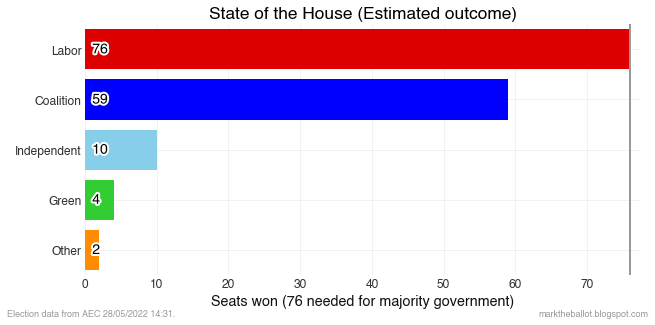

In [54]:
tally.set_manual_block([])
by_hand = {
    'Labor': ['Macnamara', 'Lingiari', 'Lyons', ],
    'Green': ['Brisbane'],
    'Coalition': ['Gilmore'],
}

for dest, bundle in by_hand.items():
    tally.move(bundle, tally.UNALLOCATED, dest)
tally.get_seat_counts()

plot_state_of_house(tally, 'State of the House (Estimated outcome)')

## The End

In [55]:
print('Done')

Done
